In [2]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import plotly.graph_objs as go
import plotly.io as pio
from mlxtend.plotting import plot_decision_regions
import xgboost as xgb
from xgboost import plot_tree
from sklearn.base import accuracy_score
from sklearn.tree import export_graphviz
import graphviz

f = '/Users/shenchingfeng/Documents/1112/機器學習/Homework 2/all.csv'

df = pd.read_csv(f)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) ## Red wine == 1 ; White wine == 0

result = pd.DataFrame(columns = ["model", "accuracy"])

select_col = df.drop('wine', axis = 1).columns
for i in select_col:
    df[i], lambda_value = stats.yeojohnson(df[i])

# Cross Validation

### 10-Fold CV

In [3]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

### Grid Search CV

In [4]:
model = xgb.XGBClassifier()

X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

params = {
    'max_depth': [1, 3, 5, 7, 9, 11],
    'n_estimators': [50, 100, 200, 250, 300]
}

grid_search = GridSearchCV(model, param_grid = params, cv = kf, n_jobs = -1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

result = result.append({
    'model': 'XGBoost', 
    'accuracy': round(grid_search.best_score_, 4)
    }, 
    ignore_index = True
)

Best parameters: {'max_depth': 3, 'n_estimators': 250}
Best score: 0.9946127790608161


/var/folders/56/1hl93h654354jd5vh2zjmd640000gn/T/ipykernel_1367/3254784765.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({


# Feature Selection

## Stepwise Selection

In [5]:
for i in range(X.shape[1]):
    sfs = SFS(
    cv = kf, 
    estimator = xgb.XGBClassifier(max_depth = 3, n_estimators = 250),
    forward = True,
    floating = True,
    k_features = i+1, 
    scoring='f1',
    n_jobs = -1
)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)
    print(sfs.k_score_)
    print("=======================================")

('chlorides',)
0.8346349635295622
('chlorides', 'total sulfur dioxide')
0.9550824038119348
('fixed acidity', 'chlorides', 'total sulfur dioxide')
0.9699601685072053
('fixed acidity', 'chlorides', 'total sulfur dioxide', 'pH')
0.9774156101154187
('fixed acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates')
0.9827477324962469
('fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates')
0.9855576065687102
('fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates')
0.9890274974696599
('fixed acidity', 'volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'quality')
0.9890274974696599
('fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'quality')
0.9890303718561396
('fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur d

In [6]:
metric_dict = sfs.get_metric_dict()
k_features = list(metric_dict.keys())
avg_scores = np.array([metric_dict[k]['avg_score'] for k in k_features])
std_devs = np.array([metric_dict[k]['std_dev'] for k in k_features])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x = k_features, y = avg_scores, 
    mode = 'lines+markers', name = 'Average Score'
    )
)

fig.update_layout(
    title = {
        'text': 'Stepwise Selection',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    }, 
    xaxis_title = {
        'text': 'Number of Features',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Performence (F1)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    width = 1200, height = 800
)

fig.show()

## Lasso

In [ ]:
X = df.drop(['wine'], axis = 1)
y = df.wine

from sklearn.linear_model import Lasso
lasso = Lasso()
params = {
    'alpha': [10**i for i in range(-10, 11)],
    'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid = params, cv = kf, n_jobs = -1)
gridlasso.fit(X, y)

print("Best alpha:", gridlasso.best_params_)
print("Best scores:", gridlasso.best_score_)

coefficients = gridlasso.best_estimator_.coef_
importance = np.abs(coefficients)
print(np.array(X.columns)[importance > 1])
print(importance)

Best alpha: {'alpha': 1e-08, 'selection': 'random'}
Best scores: 0.8312860264728428
['fixed acidity' 'volatile acidity' 'chlorides' 'pH' 'sulphates' 'alcohol']
[1.94012268e+01 3.13999017e+00 1.15308809e-01 1.18270863e-02
 2.08427751e+01 1.89202679e-02 7.04227274e-03 0.00000000e+00
 4.42252089e+01 2.38130996e+00 1.87684773e+01 2.36408251e-02]


In [ ]:
best_lasso = gridlasso.best_estimator_

alphas = np.array(gridlasso.cv_results_['param_alpha'].data, dtype = 'float')
coefs = gridlasso.cv_results_['mean_test_score']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = np.log10(alphas), y = coefs, 
    mode = 'lines+markers'
    )
)

fig.update_layout(
    title = {
        'text': 'Lasso coefficients as a function of Log alpha',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 
        'x': 0.5
    }, 
    width = 1200, height = 800,
    xaxis_title = {
        'text': 'Log(alpha)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Coefficient',
        'font': {'size': 24, 'family': 'Gulliver'}
    }, 
)

fig.show()

## Feature Group

In [7]:
Stepwise = ['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates']
Lasso =  ['fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']

feature = []

for i in df.drop('wine', axis = 1).columns:
    for i in Stepwise:
        if i not in feature:
            feature.append(i)
        else:
            continue
    for i in Lasso:
        if i not in feature:
            feature.append(i)
        else:
            continue
print(feature)

['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']


# Model

In [22]:
X = df[feature]
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

clf = xgb.XGBClassifier(max_depth = 3, n_estimators = 250)
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

## Model Performance

[7/7] features ████████████████████ Time elapsed: 0 seconds

Text(0.5, 1.0, 'Feature Importance of XGBoost')

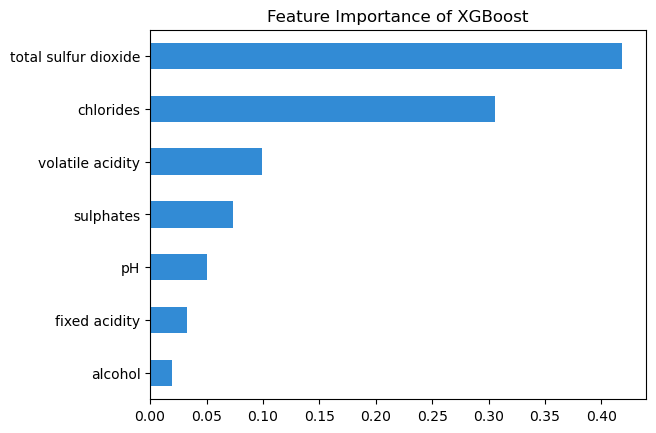

In [11]:
interpreter = Interpretation(
    x_test, feature_names = X.columns
)

pyint_model = InMemoryModel(
    model.predict_proba,
    examples = x_train
)

plots= interpreter.feature_importance.plot_feature_importance(pyint_model, ascending = False, progressbar = True)
plt.title('Feature Importance of XGBoost')

## Decision Region

In [41]:
for feature_name in X.columns:
    feature_num = X.columns.get_loc(feature_name)
    print({feature_name} , {feature_num})

{'fixed acidity'} {0}
{'volatile acidity'} {1}
{'chlorides'} {2}
{'total sulfur dioxide'} {3}
{'pH'} {4}
{'sulphates'} {5}
{'alcohol'} {6}


### With mlxtend.plotting plot_decision_regions()

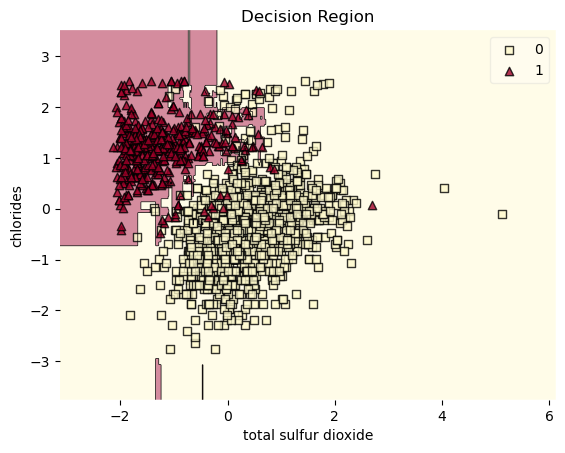

In [13]:
plot_decision_regions(
    x_test[:, [3, 2]], 
    y_test.values, 
    clf = clf.fit(x_train[:, [3, 2]], y_train.values),
    colors = '#fffacd,#a00028'
)

plt.title('Decision Region')
plt.xlabel('total sulfur dioxide')
plt.ylabel('chlorides')
plt.show()

### With Scatter plot of Plotly

In [ ]:
trace = go.Scatter(
    x = x_test[:, 1],
    y = x_test[:, 6],
    mode = 'markers',
    marker = dict(
        color = y_pred,
        symbol = y_pred,
        size = 8,
        opacity = 0.9,
        colorscale = [[0, '#fffacd'], [1, '#a00028']],
        line = dict(color = '#444444', width = 0.5)
    )
)

layout = go.Layout(
    title = {
        'text': 'Decision Region',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    },
    xaxis = dict(
        title = {
            'text': 'volatile acidity', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    yaxis = dict(
        title = {
            'text': 'total sulfur dioxide', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    margin = dict(l = 50, r = 50, t = 80, b = 50),
    hovermode = 'closest', 
    width = 800, height = 800,
    showlegend = False,
    template = 'ggplot2'
)

fig = go.Figure(
    data = [trace], 
    layout = layout
)

pio.show(fig)

## Decision Tree

In [38]:
X = df[feature]
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

clf = xgb.XGBClassifier(max_depth = 4, n_estimators = 250)
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

xgb.plot_tree(model, feature_name = X.columns)
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

<Axes: >

## Confusion Matrix

In [14]:
acu = metrics.accuracy_score(y_test, y_pred)
pre_class, r_class, f_class, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average = 'weighted')

print("Acurracy: ", round(acu * 100, 4), '%')
print('Precision:', round(pre_class * 100, 4), '%')
print('Recall:', round(r_class * 100, 4), '%')
print('f1:', round(f_class * 100, 4), '%')

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_norm = pd.DataFrame(cm_norm)
cm_norm

Acurracy:  99.4462 %
Precision: 99.4465 %
Recall: 99.4462 %
f1: 99.4451 %


,0,1
0,0.998321,0.001679
1,0.016129,0.983871


## Receiver Operating Characteristic Curve

In [17]:
fpr, tpr, _ = roc_curve(
    y_test, 
    model.predict_proba(x_test)[:, 1]
)

roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(
    x = fpr, y = tpr, 
    mode = 'lines', 
    line = dict(width = 2),
)

trace2 = go.Scatter(
        x = [0, 1], y = [0, 1],
        mode = 'lines',
        line = dict(color = 'navy', width = 2, dash = 'dash'),
        showlegend = False
)

layout = go.Layout(
        title = {
            'text': 'ROC Curves (AUC = {:0.2f})'.format(roc_auc),
            'font': {
                'size': 40, 'family': 'Gulliver'
            }, 
            'x': 0.5, 'y': 0.95
        },
        xaxis = dict(
            title = {
                'text': 'False Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        yaxis = dict(
            title = {
                'text': 'True Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        width = 1200, height = 800,
        showlegend = False
)

fig = go.Figure(
    data = [trace1, trace2], 
    layout = layout
)

fig.show()

# Model Compexity

In [20]:
n_estimators_range = range(1, 100, 10)
learning_rate_range = np.logspace(-3, 0, 10)

train_errors = []
test_errors = []

for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        xgb_clf = xgb.XGBClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state = 42, max_depth = 3)
        xgb_clf.fit(x_train, y_train)

        train_pred = xgb_clf.predict(x_train)
        test_pred = xgb_clf.predict(x_test)
        
        train_errors.append(1 - accuracy_score(y_train, train_pred))
        test_errors.append(1 - accuracy_score(y_test, test_pred))

# Convert range to list
n_estimators_range = list(n_estimators_range)
learning_rate_range = list(learning_rate_range)

# Convert the error lists to numpy arrays
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)

n_estimators, learning_rate = np.meshgrid(n_estimators_range, learning_rate_range)

train_errors = train_errors.reshape(len(n_estimators_range), len(learning_rate_range))
test_errors = test_errors.reshape(len(n_estimators_range), len(learning_rate_range))


fig = go.Figure(
    data = [go.Surface(
                x = n_estimators, y = learning_rate, z = train_errors.T, 
                colorscale = 'Blues', opacity = 0.8, name = 'Train Error'
            ),
            go.Surface(
                x = n_estimators, y = learning_rate, z = test_errors.T, 
                colorscale = 'Reds', opacity = 0.8, name = 'Test Error'
            )
    ],
    layout = go.Layout(
                title = {
                    'text': 'Model Complexity for XGBoost',
                    'font': {
                        'size': 32, 'family': 'Gulliver'
                    }, 
                    'x': 0.5
                },
                scene = dict(
                    xaxis = dict(
                                title = 'n_estimators', type = 'linear'
                            ),
                    yaxis = dict(
                                title = 'learning_rate', type = 'log'
                            ),
                    zaxis = dict(
                                title = 'Error', type = 'linear'
                            ),
                    aspectratio = dict(
                                x = 1, y = 1, z = 0.5
                            ),
                    camera = dict(
                                eye = dict(
                                    x = -1.5, y = -1.5, z = 0.5
                                )
                            ),
                ),
                margin = dict(
                            l = 0, r = 0, b = 0, t = 80
                ),
                legend = dict(
                            x = 0, y = 1, bgcolor = 'rgba(255, 255, 255, 0.5)'
                ),
    )
)

fig.show()